# RestNet

this file will use folder "dataset_used" that generate from "BreakHisModel-1.ipynb"
and this will be used transfer learning / pre trained model RestNet

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.applications import ResNet50V2
from keras.layers import Input, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping

In [2]:
# Checking their lengths
# train 
len_train_benign = len(os.listdir("../dataset_used/Cancer_train/benign/"))
len_train_malignant = len(os.listdir("../dataset_used/Cancer_train/malignant/"))
# test 
len_test_benign = len(os.listdir("../dataset_used/Cancer_test/benign/"))
len_test_malignant = len(os.listdir("../dataset_used/Cancer_test/malignant/"))
# val 
len_validation_benign = len(os.listdir("../dataset_used/Cancer_validation/benign/"))
len_validation_malignant = len(os.listdir("../dataset_used/Cancer_validation/malignant/"))

print("Training Data:")
print(" ")
print("Benign   :", len_train_benign)
print("Malignant:", len_train_malignant)
print(" ")
print("Validation Data")
print(" ")
print("Benign size    :",len_validation_benign)
print("Malignant size :",len_validation_malignant)
print(" ")
print("Testing Data:")
print(" ")
print("Benign size    :",len_test_benign)
print("Malignant size :",len_test_malignant)

Training Data:
 
Benign   : 4378
Malignant: 4378
 
Validation Data
 
Benign size    : 93
Malignant size : 244
 
Testing Data:
 
Benign size    : 380
Malignant size : 807


# Image Data Generator
- Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- Generates batches of tensor image data with real-time data augmentation.
- Thus CNN sees new set of images with different variation at each epoch.
- One of the useful methods to prevent the model from Overfitting.

In [3]:
# Defining Image Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    )

In [4]:
# Setting up the images for image data generator
train_generator = datagen.flow_from_directory(
  "../dataset_used/Cancer_train/",
  target_size=(128, 128),
  class_mode="categorical",
  batch_size = 32, 
  )
val_generator = datagen.flow_from_directory(
  "../dataset_used/Cancer_validation/", 
  target_size=(128, 128), 
  class_mode="categorical",
  batch_size=32, 
  )

Found 8756 images belonging to 2 classes.
Found 337 images belonging to 2 classes.


# model CNN 
- with RestNet

In [5]:
#Defining the base model
ResNet152V2_layer = ResNet50V2(
  include_top=False,
  input_shape=(128,128,3)
)
cancer_model = Sequential([
  # RestNet Layer
  ResNet152V2_layer,
  
  # Flattening the layers
  Flatten(),

  # Adding the dense layer
  Dense(256, activation='relu'),
  # Dropout...
  Dense(128, activation='relu'),
  Dense(2, activation='softmax'),
])

cancer_model.layers[0].trainable = False
cancer_model.summary()

94668760/94668760 [==============================] - 27s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 31,986,818
Trainable params: 8,422,018
Non-trainable params: 23,564,800
____________________________________

# HyperParameter Tuning

In [7]:
# Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.001,
  decay_steps=1000.0,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [9]:
# Compiling the model
cancer_model.compile(loss='categorical_crossentropy', 
optimizer = get_optimizer(), 
metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=10)

total time training: 49m 25.8s (16 epoch)

In [10]:
# Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(
  train_generator, 
  validation_data=val_generator, 
  epochs=200 ,
  callbacks=[early_stop], 
  verbose = 1
  )

Epoch 1/200
274/274 [==============================] - 208s 716ms/step - loss: 0.5724 - accuracy: 0.7515 - val_loss: 0.4296 - val_accuracy: 0.7864
Epoch 2/200
274/274 [==============================] - 195s 713ms/step - loss: 0.3674 - accuracy: 0.8452 - val_loss: 0.4240 - val_accuracy: 0.8190
Epoch 3/200
274/274 [==============================] - 193s 702ms/step - loss: 0.3199 - accuracy: 0.8679 - val_loss: 0.4514 - val_accuracy: 0.8131
Epoch 4/200
274/274 [==============================] - 189s 690ms/step - loss: 0.2737 - accuracy: 0.8855 - val_loss: 0.4150 - val_accuracy: 0.8398
Epoch 5/200
274/274 [==============================] - 181s 659ms/step - loss: 0.2357 - accuracy: 0.9037 - val_loss: 0.3991 - val_accuracy: 0.8576
Epoch 6/200
274/274 [==============================] - 186s 679ms/step - loss: 0.2104 - accuracy: 0.9149 - val_loss: 0.3427 - val_accuracy: 0.8576
Epoch 7/200
274/274 [==============================] - 179s 654ms/step - loss: 0.1865 - accuracy: 0.9263 - val_loss: 0

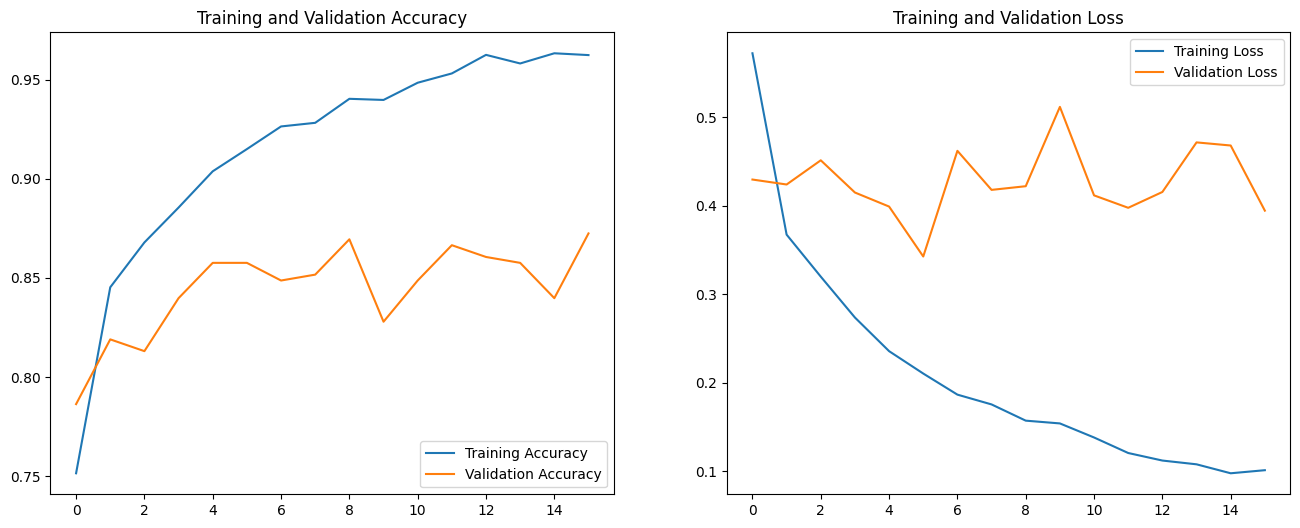

In [11]:
# Plotting the model results

# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

# No of epochs it trained
epochs_range = history.epoch

# Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory(
  "../dataset_used/Cancer_test/", 
  target_size=(128,128), 
  class_mode="categorical", 
  batch_size=1, 
  shuffle=False
  )

Found 1187 images belonging to 2 classes.


In [13]:
pred = cancer_model.evaluate(test_gen)

1187/1187 [==============================] - 61s 50ms/step - loss: 0.3828 - accuracy: 0.8652


In [12]:
# os.mkdir("../src/output/restnet")

In [14]:
cancer_model.save(filepath="../src/output/restnet/restnet50v2_model.h5")